## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


## Camera calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline

def calibare_camera():
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    object_points = [] # 3D points in real world space
    image_points = [] # 2D points in image plane.

    camera_matrix = []
    distortion_coefficients = []

    # Make a list of calibration images
    camera_image_filenames = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for camera_image_filename in camera_image_filenames:
        img = cv2.imread(camera_image_filename)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        result, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if result == True:
            object_points.append(objp)
            image_points.append(corners)
        
    result, camera_matrix, distortion_coefficients, rotation_vectors, translation_vectors = cv2.calibrateCamera(object_points, image_points, (1280, 720), None, None)
            
    return camera_matrix, distortion_coefficients

## Camera calibration samples

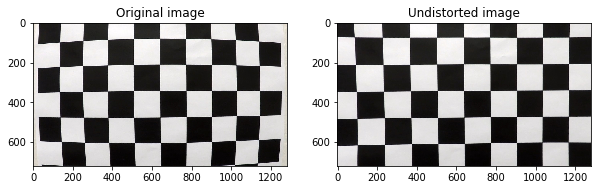

In [2]:
img = cv2.imread('../camera_cal/calibration1.jpg')
camera_matrix, distortion_coefficients = calibare_camera()

undistorted_image = cv2.undistort(img, camera_matrix, distortion_coefficients, None, camera_matrix)
            
figure, (original_image_plot, undistorted_image_plot) = plt.subplots(1, 2, figsize=(10,5))
        
original_image_plot.set_title('Original image')
original_image_plot.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

undistorted_image_plot.set_title('Undistorted image')
undistorted_image_plot.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))

## Gradient and color thresholds

In [3]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Convert to grayscale
    blured = cv2.blur(img,(7,7))
    gray = cv2.cvtColor(blured, cv2.COLOR_RGB2GRAY)
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def colorH_threshold(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    
    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    
    return binary

def colorS_threshold(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary

def colorL_threshold(img, thresh):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
    L = luv[:,:,0]
    
    binary = np.zeros_like(L)
    binary[(L > thresh[0]) & (L <= thresh[1])] = 1
    
    return binary

def colorR_threshold(img, thresh):
    R = img[:,:,0]
    
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    
    return binary

def combine_thresholds(gradx, colorR_threshold, colorS_threshold, colorH_threshold, colorL_threshold):

    combined_binary = np.zeros_like(gradx)
    combined_binary[(gradx == 1) | ((colorR_threshold == 1) | ((colorS_threshold == 1) & (colorH_threshold == 1)) | (colorL_threshold == 1))] = 1
    
    return combined_binary

## Creating undistorted and warped images

In [14]:
def warper(img, src, dst):
    image_width = img.shape[1]
    image_height = img.shape[0]

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, (image_width, image_height), flags=cv2.INTER_NEAREST)

    return warped, Minv

def warp_undistorted_image(image, camera_matrix, distortion_coefficients):
    offset = 0
    image_width = image.shape[1]
    image_height = image.shape[0]
    
    src = np.float32([[580, 445], [130, 720], [1180, 720], [730, 445]])
    
    dst = np.float32([[offset, offset], 
                      [offset, image_height - offset], 
                      [image_width - offset, image_height - offset], 
                      [image_width-offset, offset]])
    
    undistorted_image = cv2.undistort(image, camera_matrix, distortion_coefficients, None, camera_matrix)
    
    warped, Minv = warper(undistorted_image, src, dst)
    
    #cv2.polylines(undistorted_image, np.int32([src]), True, (0,0,255), 3)
    
    return warped, Minv, undistorted_image

## Loading test image set and initiating camera calibration

In [5]:
image_filenames = glob.glob('../test_images/*.jpg')

camera_matrix, distortion_coefficients = calibare_camera()

## Crating undistorted and warped images from test set

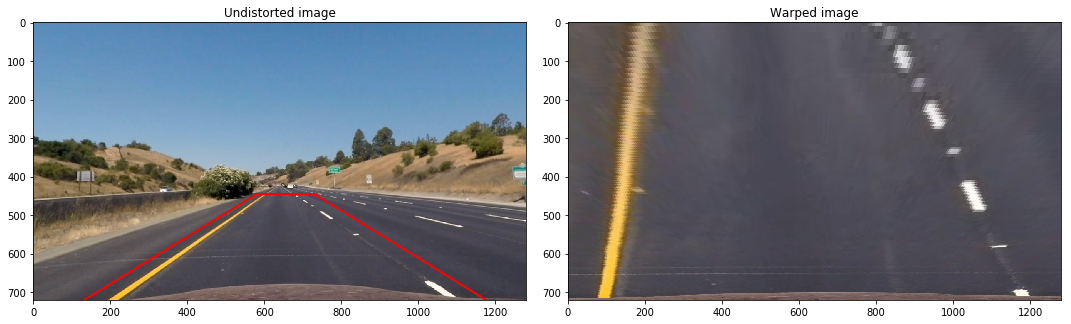

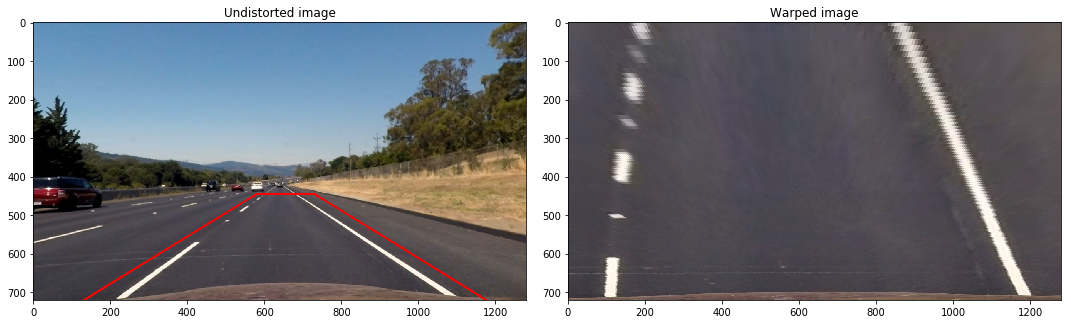

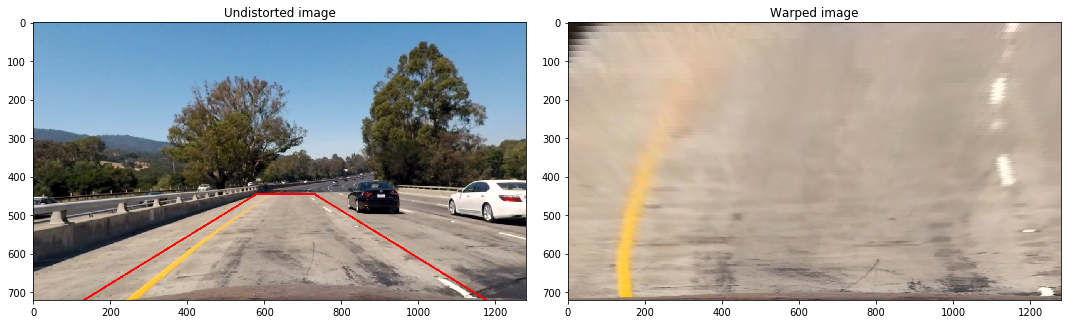

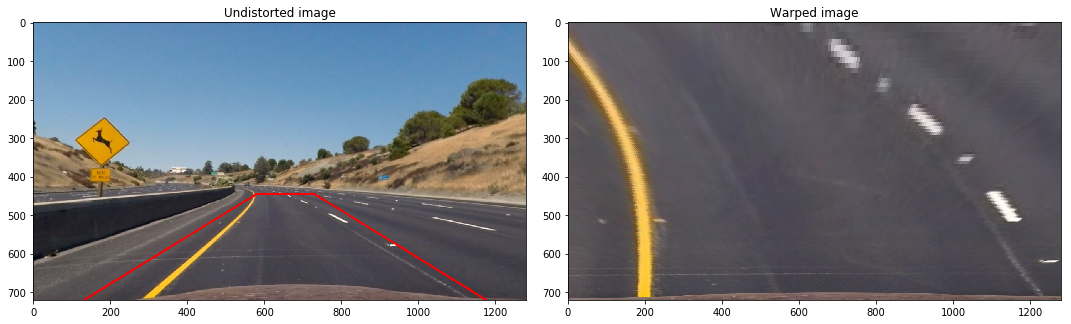

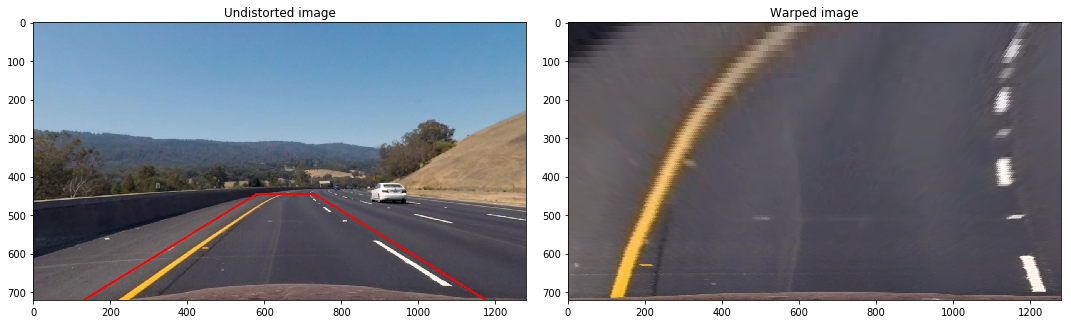

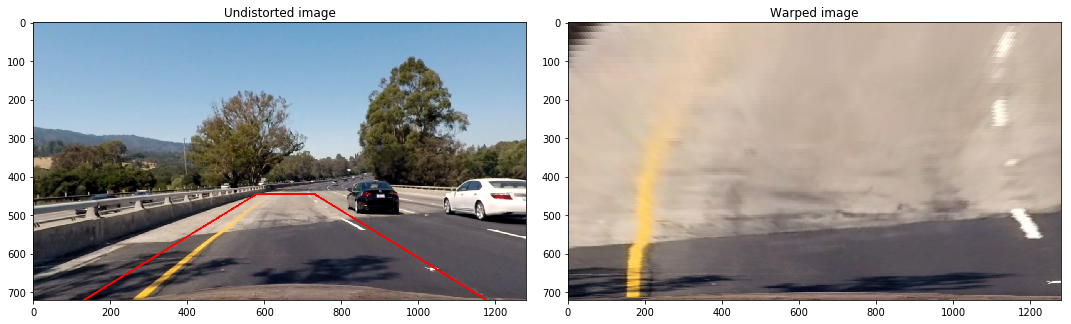

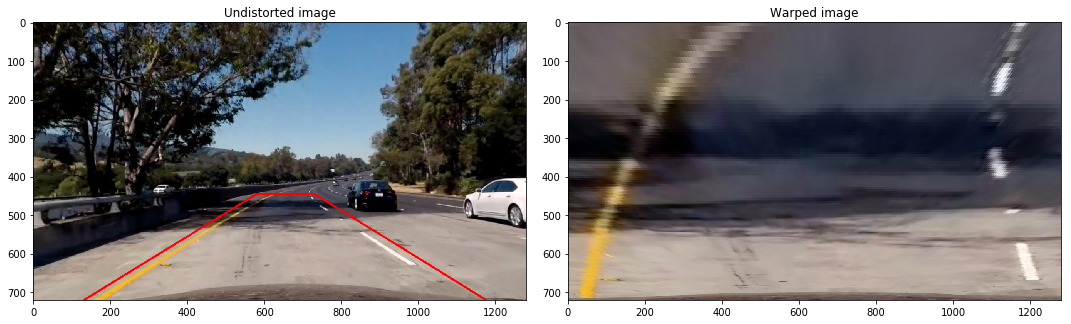

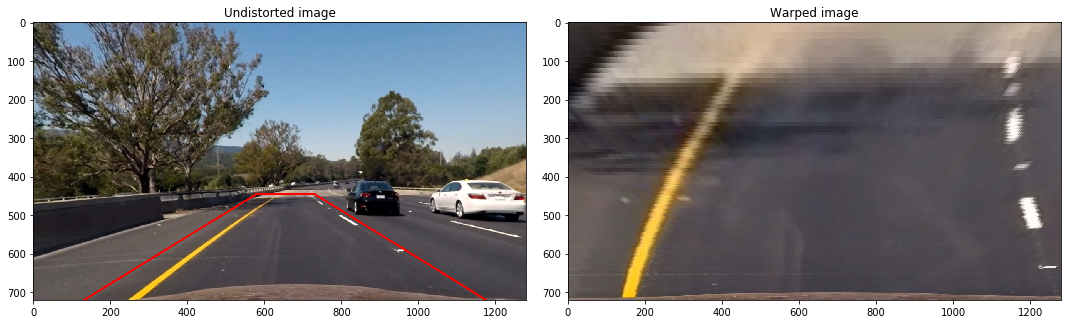

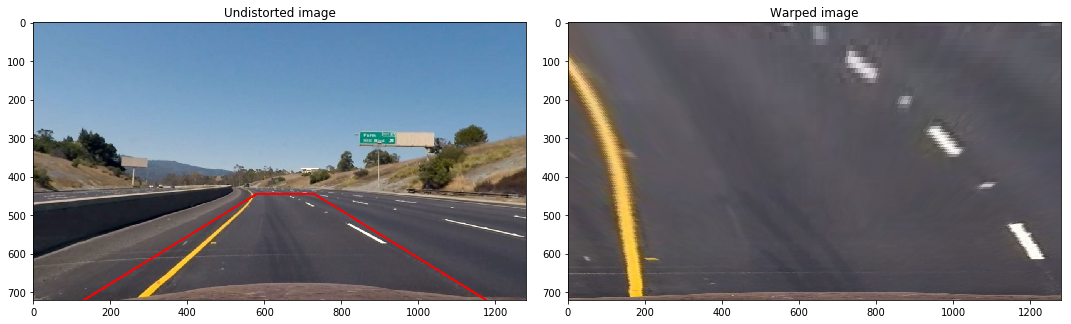

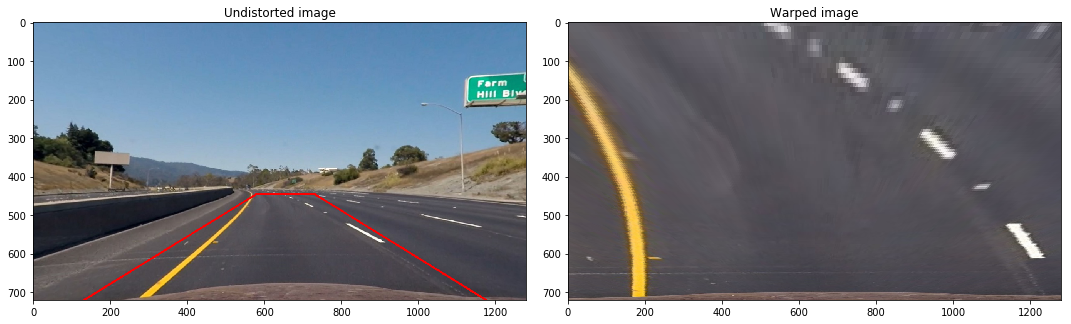

In [6]:
warped_images = []

for image_filename in image_filenames:
    img = cv2.imread(image_filename)
    
    warped, Minv, undistorted_image = warp_undistorted_image(img, camera_matrix, distortion_coefficients)
    
    warped_images.append([warped, Minv, undistorted_image])
    
    figure, (undistorted_plot, warped_plot) = plt.subplots(1, 2, figsize=(15,10))
    
    figure.tight_layout()
    
    undistorted = cv2.undistort(undistorted_image, camera_matrix, distortion_coefficients, None, camera_matrix)
        
    undistorted_plot.set_title('Undistorted image')
    undistorted_plot.imshow(cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB))
    
    warped_plot.set_title('Warped image')
    warped_plot.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

## Trying out different gradient and color thresholds

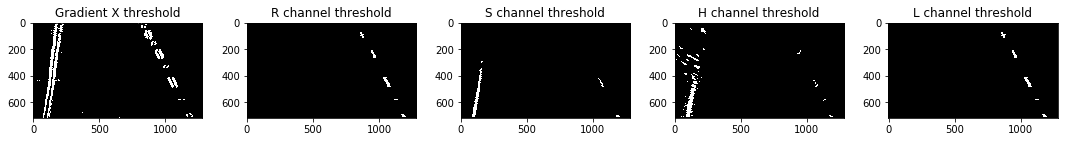

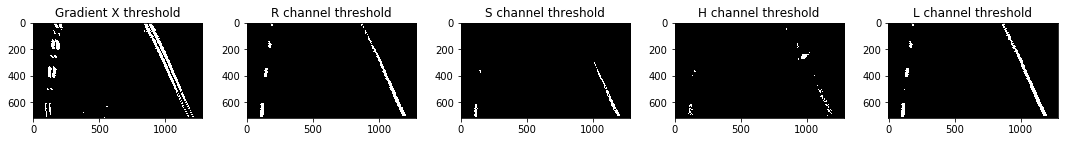

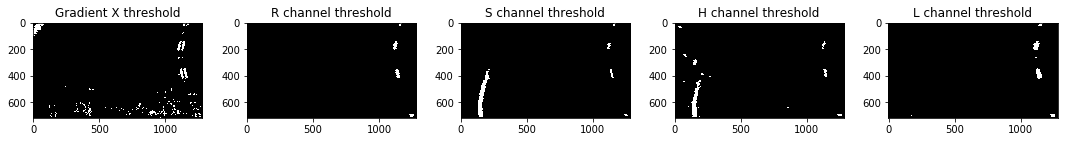

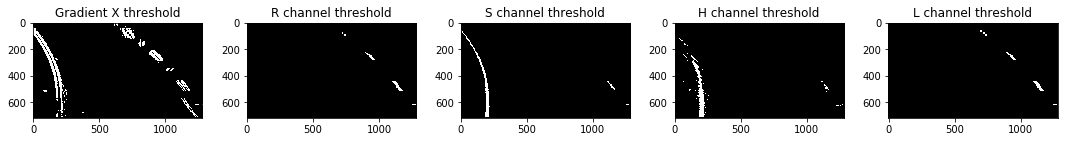

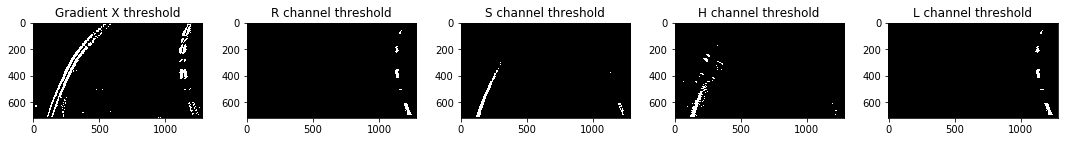

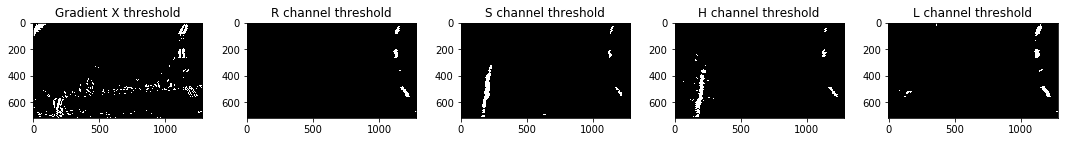

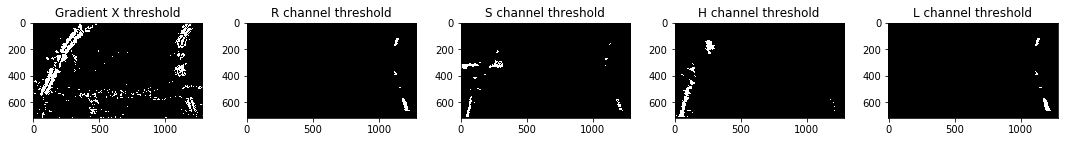

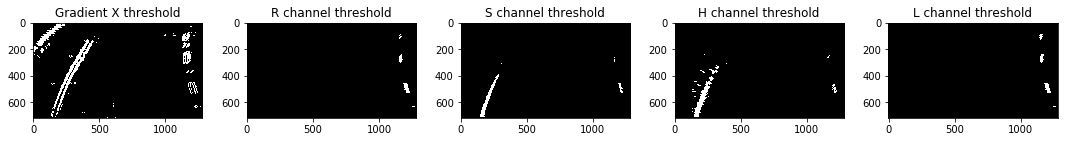

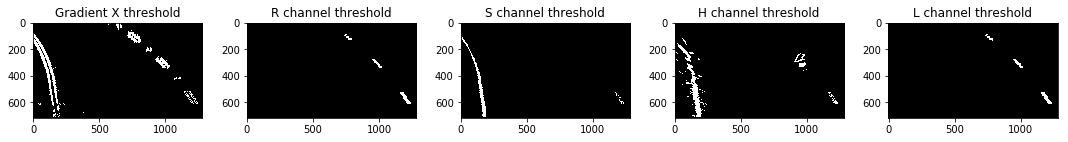

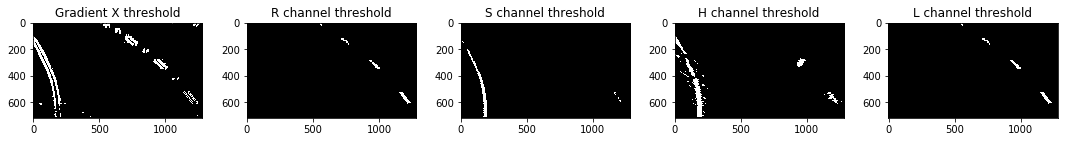

In [7]:
for warped_pair in warped_images:
    warped_image = warped_pair[0]
    
    figure, (thresholdX_plot, colorR_threshold_plot, colorS_threshold_plot, colorH_threshold_plot, colorL_threshold_plot) = plt.subplots(1, 5, figsize=(15,10))
    
    figure.tight_layout()
    
    gradx = abs_sobel_thresh(warped_image, orient='x', sobel_kernel=3, thresh_min=20, thresh_max=150)
    thresholdX_plot.set_title('Gradient X threshold')
    thresholdX_plot.imshow(gradx, cmap='gray')
    
    color_r = colorR_threshold(warped_image, thresh = (210, 255))
    colorR_threshold_plot.set_title('R channel threshold')
    colorR_threshold_plot.imshow(color_r, cmap='gray')
    
    color_s = colorS_threshold(warped_image, thresh = (190, 255))
    colorS_threshold_plot.set_title('S channel threshold')
    colorS_threshold_plot.imshow(color_s, cmap='gray')
    
    color_h = colorH_threshold(warped_image, thresh = (40, 100))
    colorH_threshold_plot.set_title('H channel threshold')
    colorH_threshold_plot.imshow(color_h, cmap='gray')
    
    color_l = colorL_threshold(warped_image, thresh = (210, 255))
    colorL_threshold_plot.set_title('L channel threshold')
    colorL_threshold_plot.imshow(color_l, cmap='gray')

## Using gradient threshold for X coordinate and combination of color thresholds

In [8]:
def combine_gradient_and_color_thresholds(image):
    gradx_threshold = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh_min=20, thresh_max=150)
    
    color_r = colorR_threshold(warped_image, thresh = (210, 255))
    color_s = colorS_threshold(image, thresh = (190, 255))
    color_h = colorH_threshold(warped_image, thresh = (40, 100))
    color_l = colorL_threshold(warped_image, thresh = (210, 255))

    return combine_thresholds(gradx_threshold, color_r, color_s, color_h, color_l)

## Applying thresholds on warped images

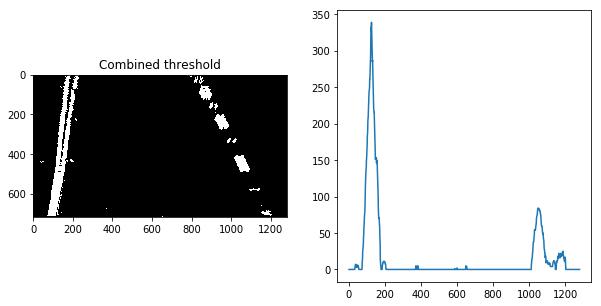

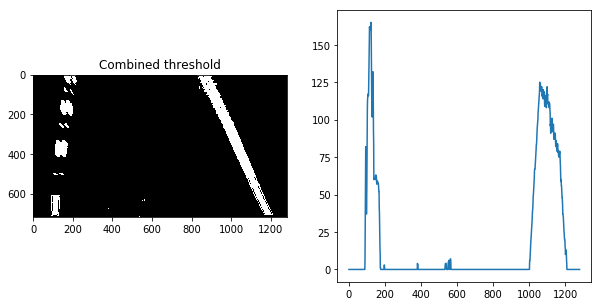

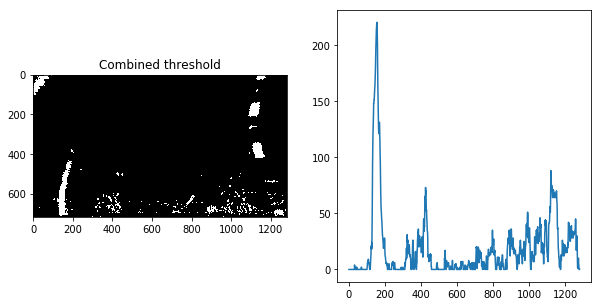

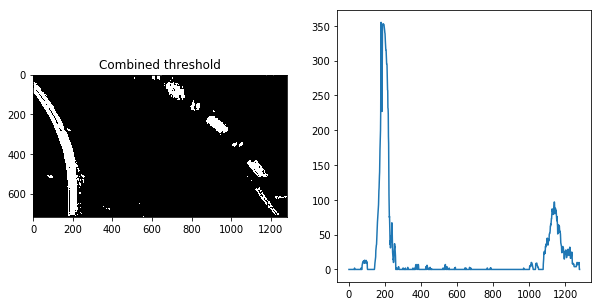

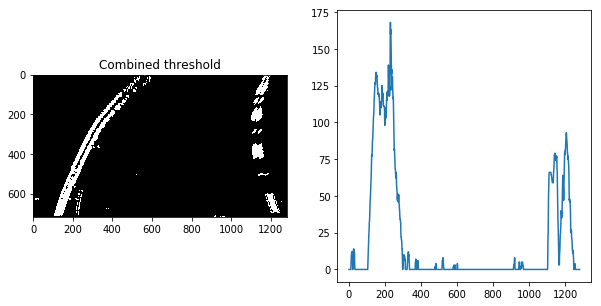

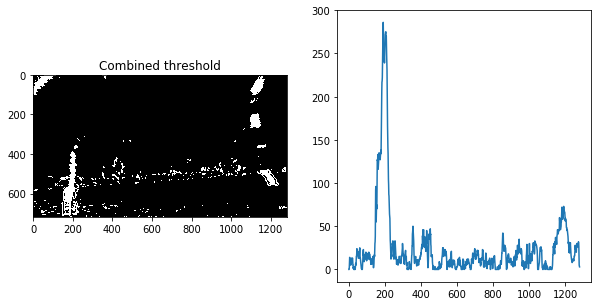

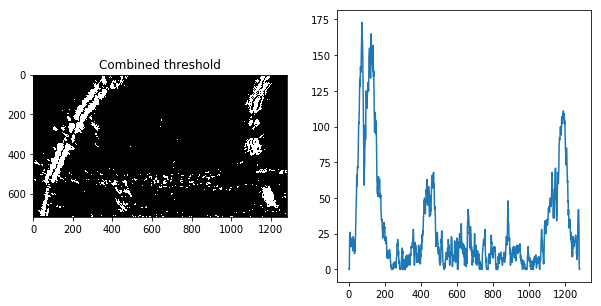

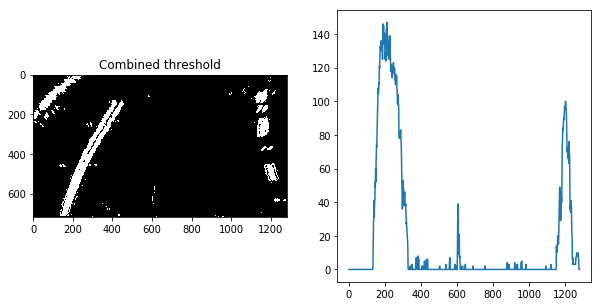

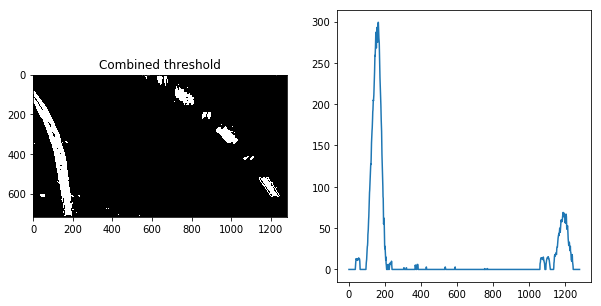

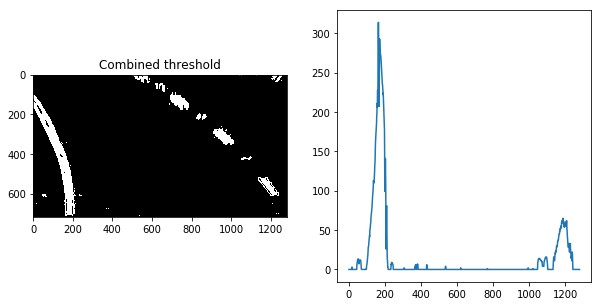

In [9]:
combined_threshold_images = []

for warped_pair in warped_images:
    warped_image = warped_pair[0]
    
    figure, (combined_threshold_plot, histogram_plot) = plt.subplots(1, 2, figsize=(10,5))
    
    combined = combine_gradient_and_color_thresholds(warped_image)
    
    combined_threshold_plot.set_title('Combined threshold')
    combined_threshold_plot.imshow(combined, cmap='gray')
    
    histogram = np.sum(combined[combined.shape[0]//2:,:], axis=0)
    histogram_plot.plot(histogram)
    
    combined_threshold_images.append(combined)

## Lane detection and marking

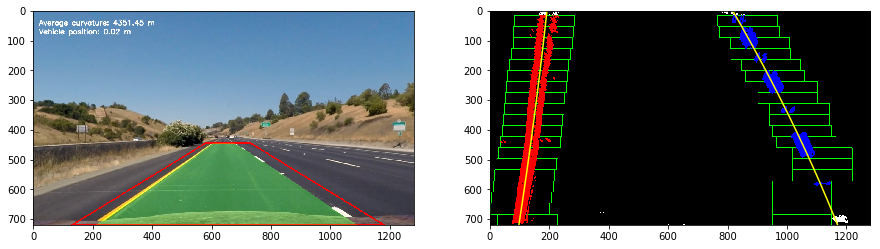

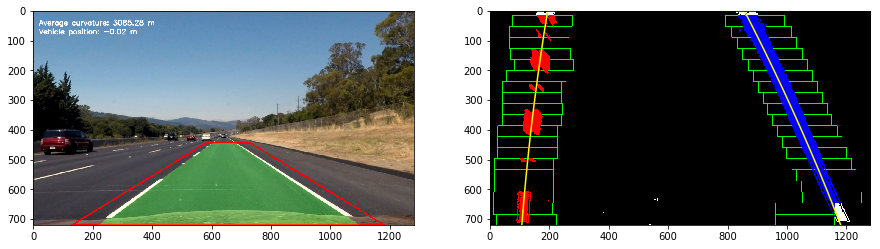

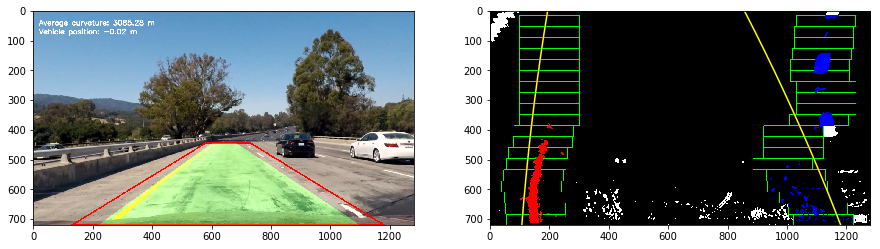

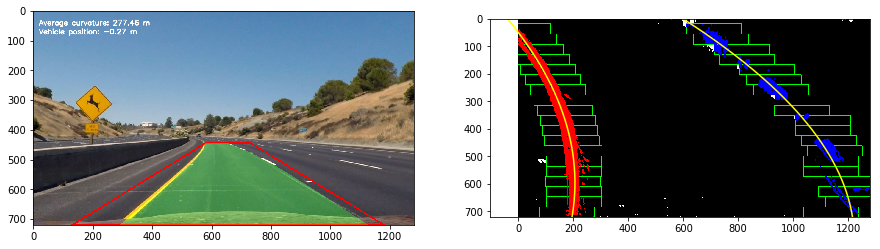

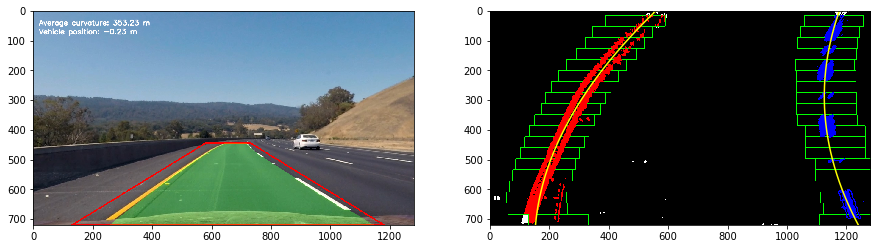

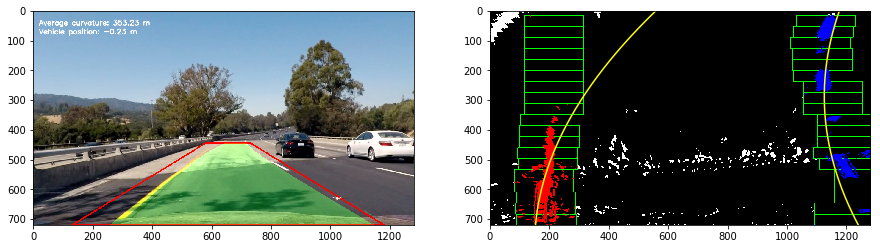

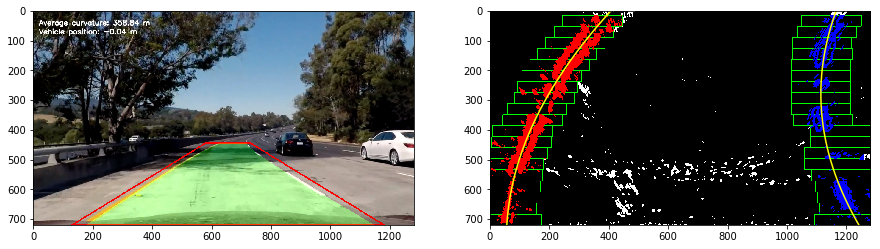

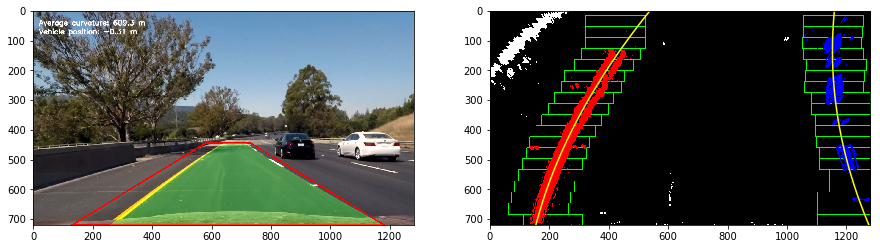

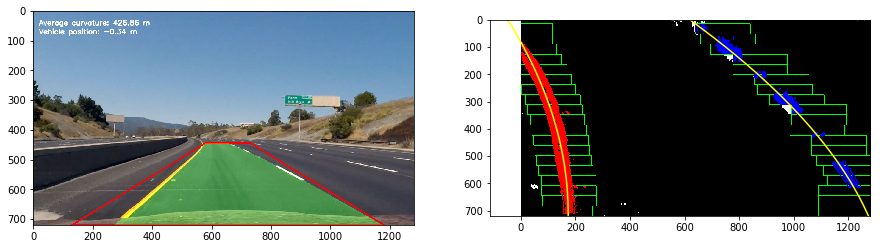

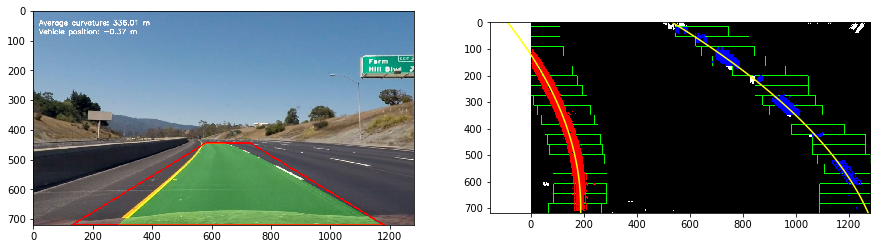

In [12]:
left_fit = None
right_fit = None

def detect_and_mark_lanes(binary_image, Minv, undistorted_image, should_plot_result):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_image[binary_image.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_image, binary_image, binary_image))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 19

    # Set height of windows
    window_height = np.int(binary_image.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 100
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    global left_fit
    global right_fit

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_image.shape[0] - (window+1)*window_height
        win_y_high = binary_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
          
    if (((rightx[0] - leftx[0]) > 1000) and ((rightx[-1] - leftx[-1]) < 1000)):
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    pts = np.hstack((pts_left, pts_right))   

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
    
    y_eval = np.max(ploty)
        
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/700 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
        
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    binary_image_center_x = binary_image.shape[1]/2
    
    left_vehicle_position_fit_x = left_fit[0]*binary_image.shape[0]**2 + left_fit[1]*binary_image.shape[0] + left_fit[2]
    right_vehicle_position_fit_x = right_fit[0]*binary_image.shape[0]**2 + right_fit[1]*binary_image.shape[0] + right_fit[2]
    
    vehicle_center_position = (right_vehicle_position_fit_x + left_vehicle_position_fit_x)/2
    vehicle_position = (binary_image_center_x - vehicle_center_position)*xm_per_pix
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,"Average curvature: " + str(round((left_curverad + right_curverad) / 2, 2)) + " m",(20,50), font, 0.8,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,"Vehicle position: " + str(round(vehicle_position, 2)) + " m",(20,80), font, 0.8,(255,255,255),2,cv2.LINE_AA)
    
    if should_plot_result:
        figure, (original_plot, binary_plot) = plt.subplots(1, 2, figsize=(15,10))
        original_plot.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        binary_plot.imshow(out_img)
        binary_plot.plot(left_fitx, ploty, color='yellow')
        binary_plot.plot(right_fitx, ploty, color='yellow')
        
    return result
    
imageCounter = 0

for combined_threshold_image in combined_threshold_images:
    result = detect_and_mark_lanes(combined_threshold_image, warped_images[imageCounter][1], warped_images[imageCounter][2], True)
    imageCounter += 1

## Video pipleline for detecting lanes

In [15]:
camera_matrix, distortion_coefficients = calibare_camera()

def find_road_lanes(temp_image):
        warped, Minv, undistorted = warp_undistorted_image(temp_image, camera_matrix, distortion_coefficients)
        combined = combine_gradient_and_color_thresholds(warped)
        return detect_and_mark_lanes(combined, Minv, undistorted, False)
        
from moviepy.editor import VideoFileClip

def process_image(temp_image):
    result = find_road_lanes(temp_image)
    
    return result

video_output = '../project_video_output.mp4'
clip = VideoFileClip("../project_video.mp4")
output_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ../project_video_output.mp4
[MoviePy] Writing video ../project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:27<00:00,  6.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_video_output.mp4 

Wall time: 3min 28s
